# Regression LSTM with best parameters


# Import libraries

In [1]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt
import time

date =  [2018010000, 
         2018030000, 
         2018050000,
         2018070000,
         2018090000,
         2018110000]

# parameters
steps = 48
n_hidden = 2
units = 100
batch_size = 48
epochs = 100
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import keras libraries, packages and data:

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers

# import data
data_full = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# Create loop for different dates:

In [3]:
# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

def regressor_tunning(kernel_initializer = 'he_uniform',
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    if n_hidden == 0:
        model.add(LSTM(units = units,                    
                       input_shape = (steps, features_num), 
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    else:
        model.add(LSTM(units = units,                    
                       input_shape = (steps, features_num), 
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        model.add(LSTM(units = units, 
                       input_shape = (steps, features_num), 
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop()
    model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
    return model
  
# LOOP STARTS
for i in date:
    start_time = time.time()
    # data
    data = data_full.loc[data_full.index > i, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # fill nan values in the whole data set
    data.fillna(data.mean(), inplace = True)

    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    data_train, data_test = train_test_split(
             data, test_size = 0.15, shuffle=False)  
    
    from sklearn.preprocessing import MinMaxScaler

    # data scaling  (including offer (y))
    sc_X = MinMaxScaler()
    data_train = sc_X.fit_transform(data_train)
    data_test = sc_X.transform(data_test)
    
    # divide features and labels
    X_train = data_train[:, 0:14] 
    y_train = data_train[:, -1]
    X_test = data_test[:, 0:14] 
    y_test = data_test[:, -1] 

    # divide data into train and test 
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.10, shuffle=False)

    # put data into correct shape
    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)

    model = regressor_tunning()
    
    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = epochs,
                        shuffle = False)
                        #validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15 (inverso should not be used as scalling was made with the whole data set)
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])

    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)
    
    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    # Need to process data with spike occurences the same way as features
    data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

    # set predictive window according with tuning best results
    data = data.loc[data.index > i, :]

    # make sure shaded area will correspond to values outputed by LSTM
    data.reset_index(drop = True, inplace = True)

    # fill_nan is already made - so lets split data into test and train
    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    shade_train, shade_test = train_test_split(
             data, test_size = 0.15, shuffle = False)

    # reset index of testing data
    shade_test.reset_index(drop = True, inplace = True)

    # function to split data into correct shape for RNN
    def split_data_shade(shade_test, steps):
        y_spike_occ = list()
        upper_lim = list()
        lower_lim = list()
        for i in range(steps, len(shade_test.index)):
            y_spike_occ.append(shade_test['spike_occurance'][i])
            upper_lim.append(shade_test['spike_upperlim'][i])
            lower_lim.append(shade_test['spike_lowerlim'][i])
        return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)
    
    # shape y_spike_occ for the right size to compare results in normal and spike regions
    y_spike_occ, spike_upperlim, spike_lowerlim = split_data_shade(shade_test, steps)

    # continue
    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)
    
    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/100
279/279 [==============================] - 29s 105ms/step - loss: 0.0649 - mse: 0.0649 - mae: 0.1577
Epoch 2/100
279/279 [==============================] - 28s 102ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0279
Epoch 3/100
279/279 [==============================] - 29s 105ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0212
Epoch 4/100
279/279 [==============================] - 28s 99ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0201
Epoch 5/100
279/279 [==============================] - 28s 101ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0196
Epoch 6/100
279/279 [==============================] - 28s 101ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0192
Epoch 7/100
279/279 [==============================] - 28s 100ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0189
Epoch 8/100
279/279 [==============================] - 28s 99ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0187
Epoch 9/100
279/279 [==============================] - 27s 95ms/step - loss: 0.0012 - mse: 0.0012 

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/100
234/234 [==============================] - 21s 88ms/step - loss: 0.0802 - mse: 0.0802 - mae: 0.1953
Epoch 2/100
234/234 [==============================] - 21s 89ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0363
Epoch 3/100
234/234 [==============================] - 20s 87ms/step - loss: 9.4911e-04 - mse: 9.4911e-04 - mae: 0.0203 3s - loss:
Epoch 4/100
234/234 [==============================] - 20s 87ms/step - loss: 8.2767e-04 - mse: 8.2767e-04 - mae: 0.0184 6s - loss: 7.3837e-04 - mse: 7.3837e-04 - mae: 0.0 - ETA: 5s -  - ETA: 1s - loss: 8.4683e-04 - mse: 8.4
Epoch 5/100
234/234 [==============================] - 22s 92ms/step - loss: 7.8100e-04 - mse: 7.8100e-04 - mae: 0.0176
Epoch 6/100
234/234 [==============================] - 20s 84ms/step - loss: 7.5082e-04 - mse: 7.5082e-04 - mae: 0.0171
Epoch 7/100
234/234 [==============================] - 21s 89ms/step - loss: 7.2099e-04 - mse: 7.2099e-04 - mae: 0.0166
Epoch 8/100
234/234 [==============================] - 20s 87

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/100
187/187 [==============================] - 17s 89ms/step - loss: 0.0844 - mse: 0.0844 - mae: 0.2096
Epoch 2/100
187/187 [==============================] - 17s 89ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0490 2s - loss: 0.0047 - m
Epoch 3/100
187/187 [==============================] - 17s 90ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0222
Epoch 4/100
187/187 [==============================] - 20s 105ms/step - loss: 7.4373e-04 - mse: 7.4373e-04 - mae: 0.0179
Epoch 5/100
187/187 [==============================] - 20s 108ms/step - loss: 6.7945e-04 - mse: 6.7945e-04 - mae: 0.0167
Epoch 6/100
187/187 [==============================] - 25s 136ms/step - loss: 6.4053e-04 - mse: 6.4053e-04 - mae: 0.0159
Epoch 7/100
187/187 [==============================] - 19s 103ms/step - loss: 6.1727e-04 - mse: 6.1727e-04 - mae: 0.0156
Epoch 8/100
187/187 [==============================] - 20s 106ms/step - loss: 5.9089e-04 - mse: 5.9089e-04 - mae: 0.0153
Epoch 9/100
187/187 [================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/100
140/140 [==============================] - 12s 89ms/step - loss: 0.1163 - mse: 0.1163 - mae: 0.2443 2s - loss: 0.1415 - mse - ETA: 1s - loss: 0.1237 - mse: 0.1237 
Epoch 2/100
140/140 [==============================] - 12s 85ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0780
Epoch 3/100
140/140 [==============================] - 13s 90ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0358
Epoch 4/100
140/140 [==============================] - 12s 88ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0230
Epoch 5/100
140/140 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0010 - mae: 0.019 - 9s 65ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0193
Epoch 6/100
140/140 [==============================] - 11s 82ms/step - loss: 9.3029e-04 - mse: 9.3029e-04 - mae: 0.0182
Epoch 7/100
140/140 [==============================] - 13s 93ms/step - loss: 8.9460e-04 - mse: 8.9460e-04 - mae: 0.0174
Epoch 8/100
140/140 [==============================] - 13s 95ms/step - loss: 8.6950e-

140/140 [==============================] - 11s 76ms/step - loss: 6.5248e-04 - mse: 6.5248e-04 - mae: 0.0130
Epoch 68/100
140/140 [==============================] - 9s 67ms/step - loss: 6.4823e-04 - mse: 6.4823e-04 - mae: 0.0129
Epoch 69/100
140/140 [==============================] - 10s 69ms/step - loss: 6.4271e-04 - mse: 6.4271e-04 - mae: 0.0129
Epoch 70/100
140/140 [==============================] - 13s 90ms/step - loss: 6.4386e-04 - mse: 6.4386e-04 - mae: 0.0128
Epoch 71/100
140/140 [==============================] - 13s 91ms/step - loss: 6.4670e-04 - mse: 6.4670e-04 - mae: 0.0128
Epoch 72/100
140/140 [==============================] - 13s 92ms/step - loss: 6.4923e-04 - mse: 6.4923e-04 - mae: 0.0130
Epoch 73/100
140/140 [==============================] - 13s 91ms/step - loss: 6.3639e-04 - mse: 6.3639e-04 - mae: 0.0128
Epoch 74/100
140/140 [==============================] - 13s 92ms/step - loss: 6.3400e-04 - mse: 6.3400e-04 - mae: 0.0128
Epoch 75/100
140/140 [========================

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/100
93/93 [==============================] - 9s 97ms/step - loss: 0.1589 - mse: 0.1589 - mae: 0.3040:
Epoch 2/100
93/93 [==============================] - 9s 94ms/step - loss: 0.0323 - mse: 0.0323 - mae: 0.1394
Epoch 3/100
93/93 [==============================] - 8s 87ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0648: 1s - loss: 0.0080 - mse: 0.00
Epoch 4/100
93/93 [==============================] - 9s 95ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0364
Epoch 5/100
93/93 [==============================] - 9s 95ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0261
Epoch 6/100
93/93 [==============================] - 8s 86ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0216
Epoch 7/100
93/93 [==============================] - 9s 93ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0203
Epoch 8/100
93/93 [==============================] - 9s 94ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0192
Epoch 9/100
93/93 [==============================] - 8s 89ms/step - loss: 0.0012 - mse: 0.0012 -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/100
46/46 [==============================] - 4s 88ms/step - loss: 0.2595 - mse: 0.2595 - mae: 0.3561
Epoch 2/100
46/46 [==============================] - 5s 105ms/step - loss: 0.0796 - mse: 0.0796 - mae: 0.2243
Epoch 3/100
46/46 [==============================] - 5s 109ms/step - loss: 0.0339 - mse: 0.0339 - mae: 0.1464
Epoch 4/100
46/46 [==============================] - 4s 93ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0951
Epoch 5/100
46/46 [==============================] - 4s 86ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0660
Epoch 6/100
46/46 [==============================] - 5s 104ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0452
Epoch 7/100
46/46 [==============================] - 4s 83ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0341
Epoch 8/100
46/46 [==============================] - 4s 95ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0274
Epoch 9/100
46/46 [==============================] - 4s 97ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0234
Epoch 10/100
46/

In [5]:
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
    
                        'time': time_count})


results.to_csv('Results_LSTM_Prediction_window.csv')

y_pred_list = pd.Series(y_pred_list)
y_pred_list.to_csv('Predictions_LSTM_Prediciton_window.csv')

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
0,34.702559,19.231377,37.835269,23.575568,34.089546,18.425198,2628.828525
1,33.647487,18.686308,49.478404,25.667431,29.674810,17.351794,2147.957236
2,28.726050,18.082183,35.200142,22.865714,27.465006,17.263175,2126.208786
3,28.768448,18.254439,38.626341,26.154838,27.065545,17.123792,1267.839622
4,27.735268,16.304950,35.707724,20.731525,26.368431,15.657754,844.234468
5,25.198536,15.745488,40.099320,24.857837,21.427197,14.098678,431.979775


In [6]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
0,34.702559,19.231377,37.835269,23.575568,34.089546,18.425198,2628.828525
1,33.647487,18.686308,49.478404,25.667431,29.674810,17.351794,2147.957236
2,28.726050,18.082183,35.200142,22.865714,27.465006,17.263175,2126.208786
3,28.768448,18.254439,38.626341,26.154838,27.065545,17.123792,1267.839622
4,27.735268,16.304950,35.707724,20.731525,26.368431,15.657754,844.234468
5,25.198536,15.745488,40.099320,24.857837,21.427197,14.098678,431.979775


In [7]:
results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal,time
0,34.702559,19.231377,37.835269,23.575568,34.089546,18.425198,2628.828525
1,33.647487,18.686308,49.478404,25.667431,29.674810,17.351794,2147.957236
2,28.726050,18.082183,35.200142,22.865714,27.465006,17.263175,2126.208786
3,28.768448,18.254439,38.626341,26.154838,27.065545,17.123792,1267.839622
4,27.735268,16.304950,35.707724,20.731525,26.368431,15.657754,844.234468
5,25.198536,15.745488,40.099320,24.857837,21.427197,14.098678,431.979775


<IPython.core.display.Javascript object>


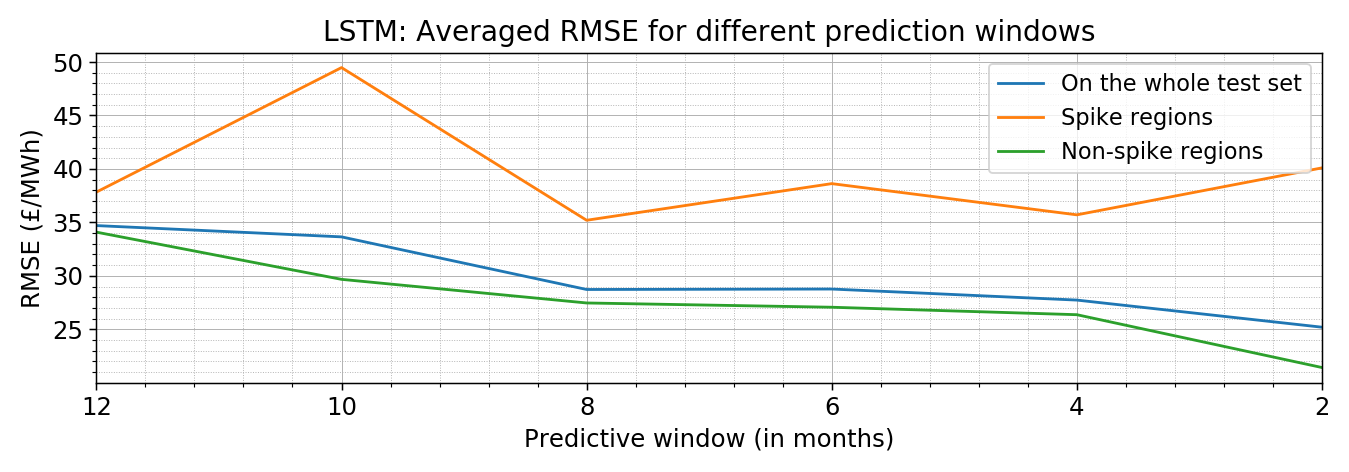

<IPython.core.display.Javascript object>


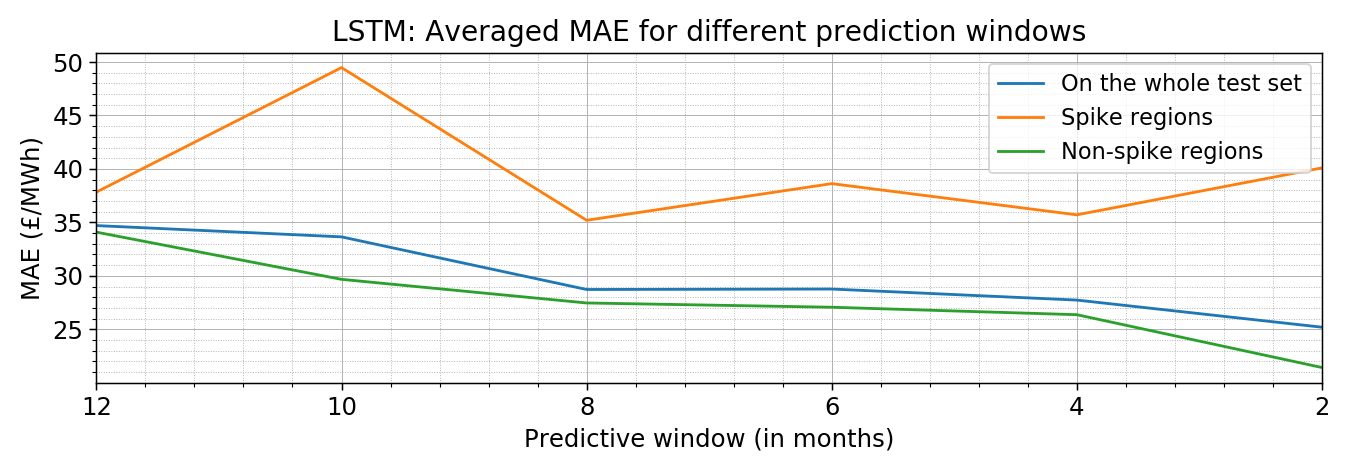

In [30]:
%matplotlib notebook

fontsize = 13

date_labels =   ['12', 
                 '10', 
                 '8',
                 '6', 
                 '4', 
                 '2']

plt.figure(figsize=(10,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('LSTM: Averaged RMSE for different prediction windows', fontsize = fontsize + 2)
plt.plot([0,1,2,3,4,5], rmse_gen, label = 'On the whole test set')
plt.plot([0,1,2,3,4,5], rmse_spi, label = 'Spike regions')
plt.plot([0,1,2,3,4,5], rmse_nor, label = 'Non-spike regions')
plt.legend(loc = 'upper right', fontsize = fontsize - 1)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xlabel('Predictive window (in months)', fontsize = fontsize)
plt.xticks([0,1,2,3,4,5], list(np.arange(2, 14, 2))[::-1], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, 5)
plt.tight_layout()
plt.savefig('Predictive_window_tuning5_RMSE.png')

plt.figure(figsize=(10,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('LSTM: Averaged MAE for different prediction windows', fontsize = fontsize + 2)
plt.plot([0,1,2,3,4,5], rmse_gen, label = 'On the whole test set')
plt.plot([0,1,2,3,4,5], rmse_spi, label = 'Spike regions')
plt.plot([0,1,2,3,4,5], rmse_nor, label = 'Non-spike regions')
plt.legend(loc = 'upper right', fontsize = fontsize - 1)
plt.ylabel('MAE (£/MWh)', fontsize = fontsize)
plt.xlabel('Predictive window (in months)', fontsize = fontsize)
plt.xticks([0,1,2,3,4,5], list(np.arange(2, 14, 2))[::-1], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlim(0, 5)
plt.tight_layout()
plt.savefig('Predictive_window_tuning5_MAE.png')

In [ ]:
%matplotlib notebook

w_plot = 200 # 3 days
fontsize = 13

y_pred_1 = y_pred_list[4]
y_pred_2 = y_pred_list[5]

plt.figure(figsize=(12.5,))
plt.plot(np.arange(0, w_plot), y_test[-w_plot:], label = 'Real values', linewidth = 2, color = 'steelblue')
plt.plot(np.arange(0, w_plot), y_pred_1[-w_plot:], label = '4 months', linewidth = 1.5, color= 't')
plt.plot(np.arange(0, w_plot), y_pred_2[-w_plot:], label = '2 months', linewidth = 1.5, color = 'darkorange')
plt.fill_between(np.arange(0, w_plot),  data['spike_lowerlim'][-w_plot:], data['spike_upperlim'][-w_plot:], facecolor='skyblue', alpha=0.5, label = 'Spike delimitator')
plt.ylim(50, 260)
plt.xlim(0, w_plot - 1)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([50,100, 150, 200, 250],[50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('LSTM stateless: Predictions using 2 and 4 months of data set', fontsize = fontsize + 2)
plt.legend(loc = 'upper right', fontsize = fontsize - 2)
plt.tight_layout()
plt.savefig('LSTM_pred_2_4_months_tuning5.png')

